# TS5 - Estimacion espectral: ANcho de banda de señales reales


### Consignas

En el repositorio PDStestbench encontrará tres tipos de señales registradas:

Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

Bonus:

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.

### Introduccion


A partir de esto, en este trabajo nuestro objetivo va a ser el calcular la densidad espectral de potencia de señales estocasticas que en este caso vamos a tener señales biologicas ( ECG - PPG ) y tambien de audio ( La cucaracha ). De esta manera, ahora no conocemos los detalles de la señal como antes sabiamos el ruido, la frecuencia, etc 

Por lo que, ahora estamos en una situacion mas realista en la cual tenemos una señal muestreada para poder trabajar con esta misma. Con lo que, como primer paso buscamos calcular la densidad espectral de potencia de las señales con alguno de los metodos que ya hemos visto. En este caso vamos a utilizar Welch y Blackmann tuckey para obtener la PSD de las señales a analizar. 

Por otro lado, una vez obtengamos la PSD de las señales tenemos que lograr conseguir el ancho de banda en el cual tenemos el 95% o 98% de la potencia de la señal. De esta manera, en este BW consideramos que esta toda la señal o la parte " util de la señal " y es con lo que vamos a querer trabajar luego de procesarla de esta manera 




### Implementacion

Para todo esto vamos a generar un codigo en el cual trabajemos con la señal de audio, el ECG y la PPG. Con cada una de ellas vamos a:

* Cargar la señal en el script
* Normalizar la señal y pasarla a db
* Calcular la PSD
* Calcular el BW hasta tener el 95% y 98% de la potencia de la señal
* Graficamos señal original, PSD y BW



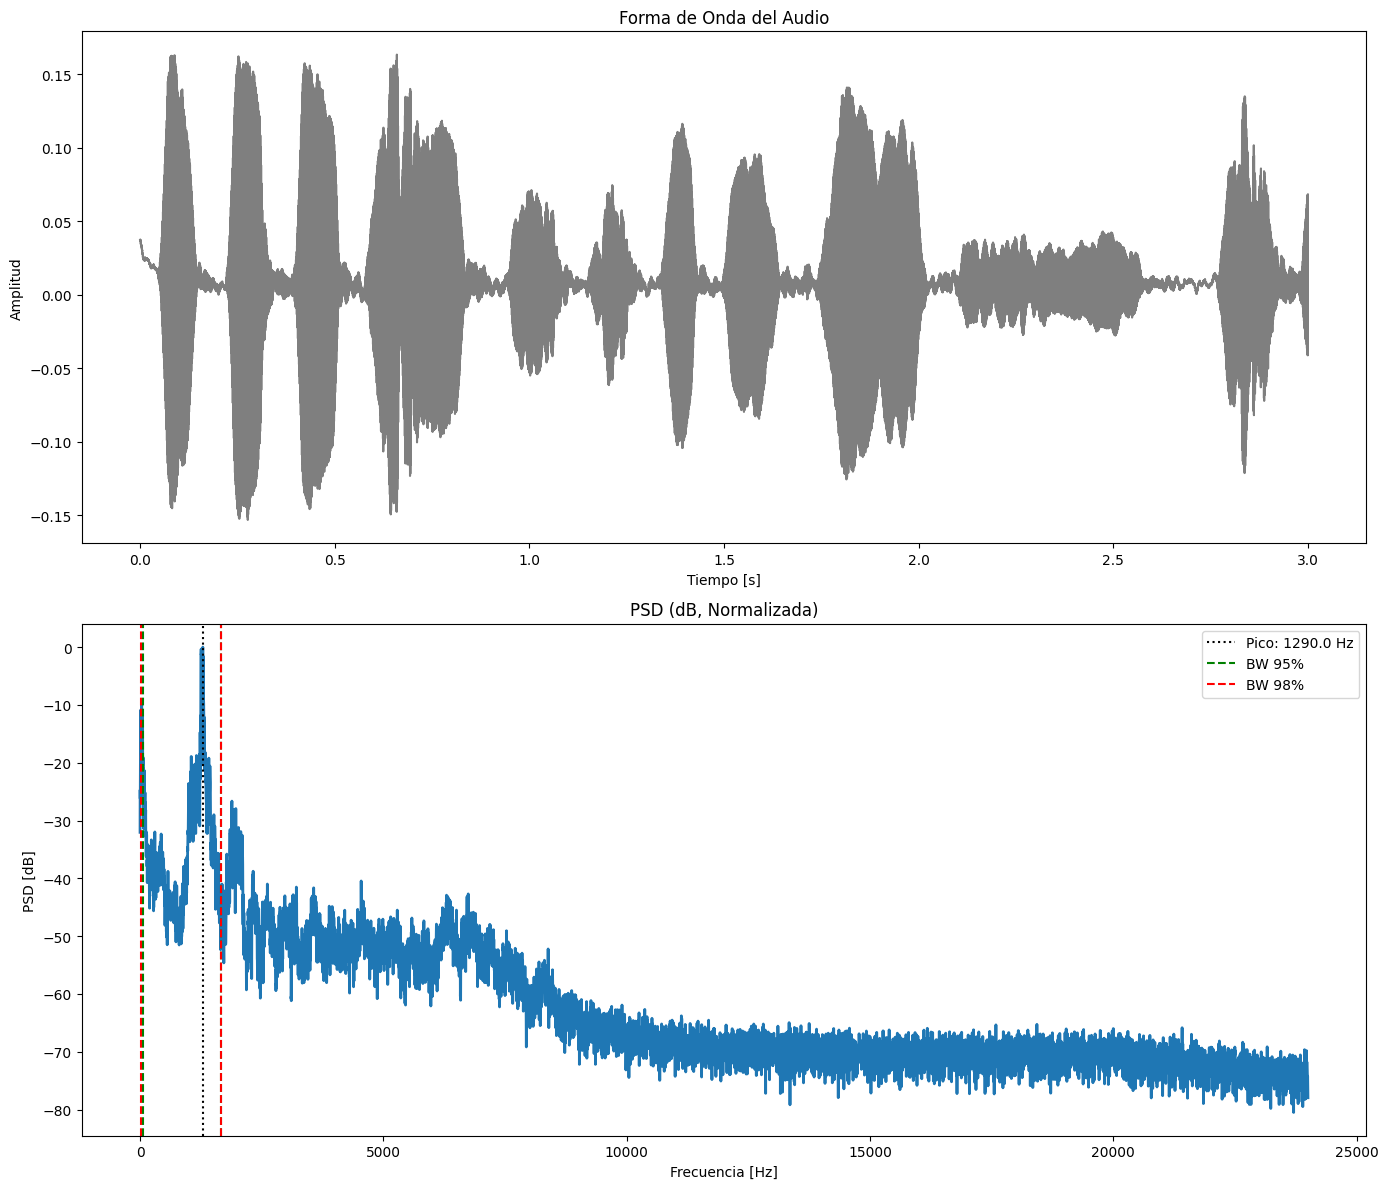

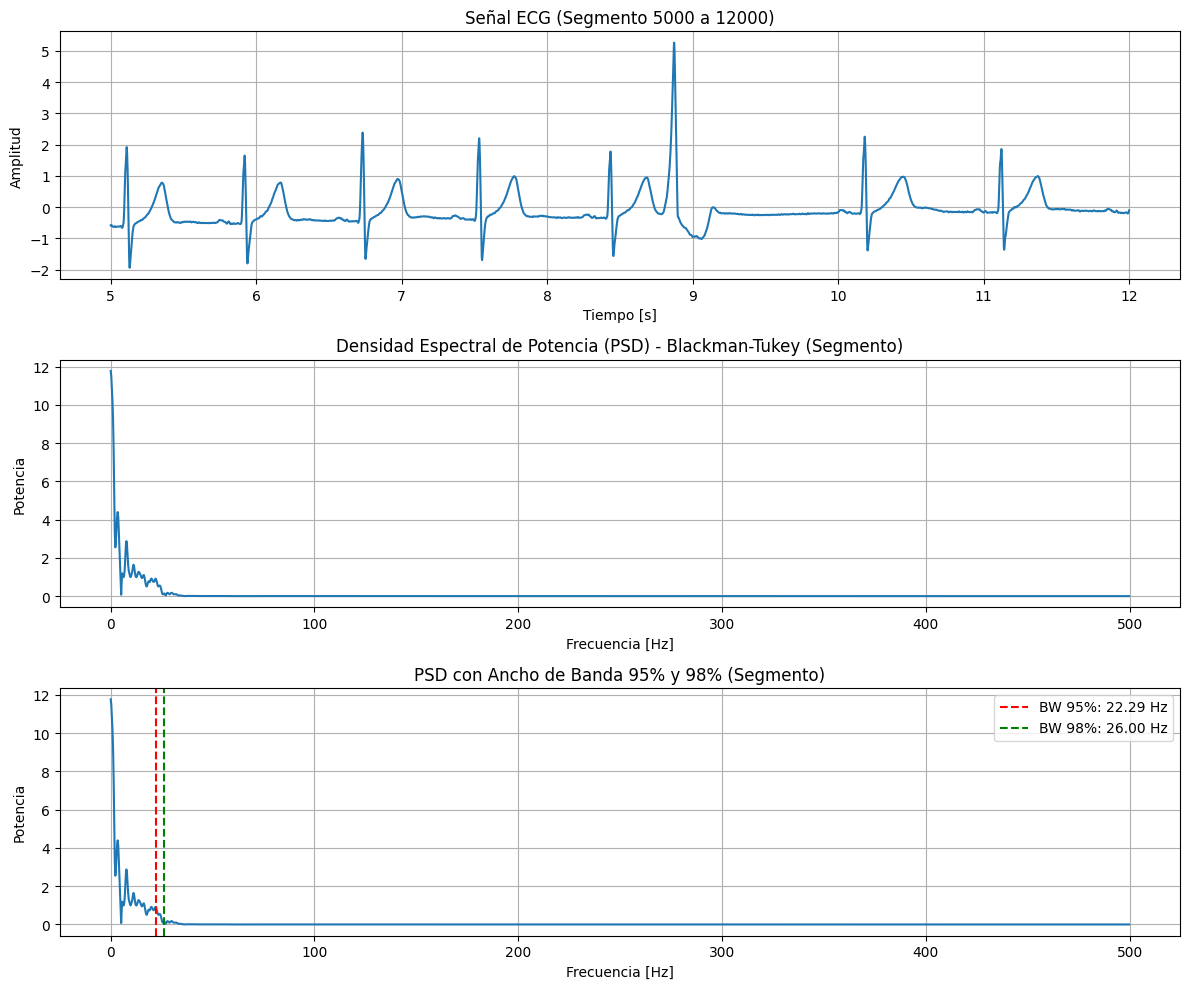

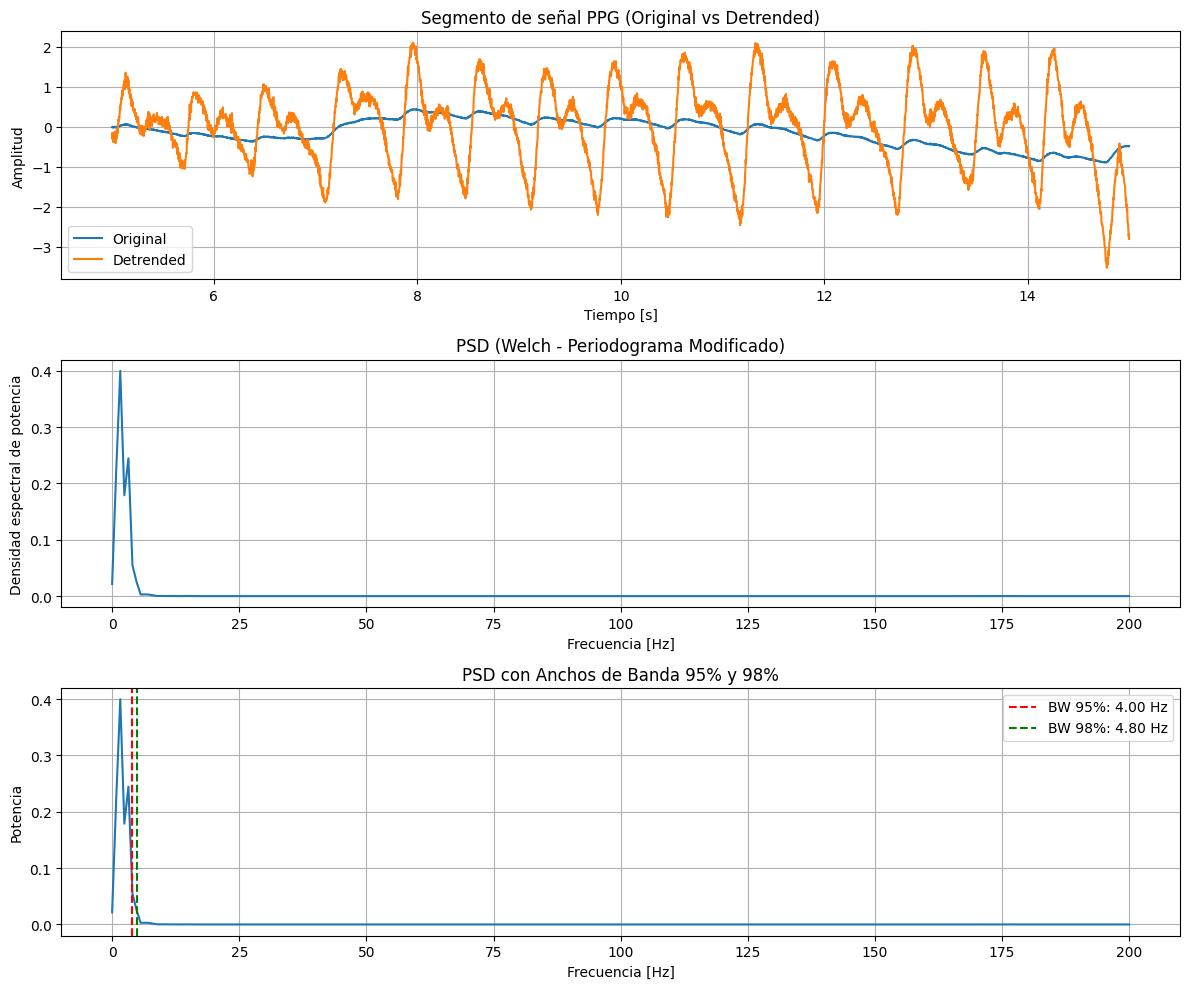


=== Tabla Comparativa de Ancho de Banda (BW) por Señal y Método PSD ===

Señal     Método PSD Segmento usado  Fs [Hz]  Ventana  BW 95% [Hz]  BW 98% [Hz]
Audio          Welch       Completo    48000     Hann      1594.00       1636.0
  ECG Blackman-Tukey     5000-12000     1000 Blackman        22.29         26.0
  PPG          Welch      2000-6000      400  Hamming         4.00          4.8


In [2]:
#%% Importado de modulos

import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io.wavfile import write
from scipy import signal
from scipy.signal import welch
from scipy.signal.windows import hamming, hann, blackman, kaiser, flattop, blackmanharris
from scipy.fft import fft, fftshift
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import os
from scipy.fft import fft
import pandas as pd

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

#%% Arvhico de Audio

# Cargar el archivo CSV como un array de NumPy

fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')
# fs_audio, wav_data = sio.wavfile.read('prueba psd.wav')
# fs_audio, wav_data = sio.wavfile.read('silbido.wav')

# Calculo largo y defino solapamiento de Welch

N = len(wav_data)
nperseg = N // 6 

# Calculo PDS con Welch

Fs_Audio_welch, Signal_Audio_Pxx = welch(x = wav_data , 
                                         fs = fs_audio, 
                                         window='hann', 
                                         nperseg = nperseg,
                                         noverlap = nperseg//2, 
                                         nfft=None, 
                                         detrend='linear', 
                                         return_onesided=True, 
                                         scaling='spectrum', 
                                         axis=0, 
                                         average='median')

# Convertir a decibeles
Signal_Audio_Pxx_mean_db = 10 * np.log10(Signal_Audio_Pxx)

Signal_Audio_Pxx_mean_db -= np.max(Signal_Audio_Pxx_mean_db )  

 
"""

Esto es normalizar el maximo a 0db. Esto tiene sentido porque tenemos distintos BW, 
para centrar todo en un mismo punto o que los picos esten en la misma escala

"""

#%% Calculo de ancho de banda

"""
Como tenemos una señal de audio, buscamos el pico maximo y a partir de alli nos movemos a los costados
de manera de ir avanzando hasta encontrar el 95 o 98 % del valor maximo de la señal. 

"""

# Paso 1: Potencia total
potencia_total = np.sum(Signal_Audio_Pxx)

# Paso 2: Índice del pico principal
peak_index = np.argmax(Signal_Audio_Pxx)

# Paso 3: Inicialización para acumulación centrada
acumulada = Signal_Audio_Pxx[peak_index]
i_low = peak_index
i_high = peak_index

# Umbrales deseados
umbral_95 = 0.95 * potencia_total
umbral_98 = 0.98 * potencia_total

# Guardamos BW cuando se cumplan los umbrales
bw_95_found = False
bw_98_found = False

# Paso 4: Expandir hacia los costados
while not bw_98_found and (i_low > 0 or i_high < len(Signal_Audio_Pxx) - 1):
    # Expandimos hacia el lado con mayor potencia siguiente
    if i_low > 0 and (i_high == len(Signal_Audio_Pxx) - 1 or Signal_Audio_Pxx[i_low - 1] >= Signal_Audio_Pxx[i_high + 1]):
        i_low -= 1
        acumulada += Signal_Audio_Pxx[i_low]
    elif i_high < len(Signal_Audio_Pxx) - 1:
        i_high += 1
        acumulada += Signal_Audio_Pxx[i_high]

    # Guardar anchos de banda cuando se alcanzan umbrales
    if not bw_95_found and acumulada >= umbral_95:
        bw_95_low = Fs_Audio_welch[i_low]
        bw_95_high = Fs_Audio_welch[i_high]
        bw_95_found = True

    if not bw_98_found and acumulada >= umbral_98:
        bw_98_low = Fs_Audio_welch[i_low]
        bw_98_high = Fs_Audio_welch[i_high]
        bw_98_found = True

# Ancho de banda centrado
bw_95 = bw_95_high - bw_95_low
bw_98 = bw_98_high - bw_98_low

# BW Para cuadro 
bw_95_audio = bw_95
bw_98_audio = bw_98

#%% Subplots: Forma de onda + PSD dB + PSD Lineal con sombreado
#plt.style.use('seaborn-v0_8-darkgrid')
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Anotar la frecuencia del pico principal
peak_idx = np.argmax(Signal_Audio_Pxx_mean_db)
peak_freq = Fs_Audio_welch[peak_idx]

# 1. Señal de audio
tiempo = np.arange(N) / fs_audio
axs[0].plot(tiempo, wav_data, color='tab:gray')
axs[0].set_title("Forma de Onda del Audio")
axs[0].set_xlabel("Tiempo [s]")
axs[0].set_ylabel("Amplitud")

# 2. PSD en dB normalizada
axs[1].plot(Fs_Audio_welch, Signal_Audio_Pxx_mean_db, color='tab:blue', lw=2)
axs[1].axvline(peak_freq, color='black', linestyle=':', label=f'Pico: {peak_freq:.1f} Hz')
axs[1].axvline(bw_95_low, color='green', linestyle='--', label=f'BW 95%')
axs[1].axvline(bw_95_high, color='green', linestyle='--')
axs[1].axvline(bw_98_low, color='red', linestyle='--', label=f'BW 98%')
axs[1].axvline(bw_98_high, color='red', linestyle='--')
axs[1].set_title("PSD (dB, Normalizada)")
axs[1].set_xlabel("Frecuencia [Hz]")
axs[1].set_ylabel("PSD [dB]")
axs[1].legend()

plt.tight_layout()
plt.show()

#%%  -------------- ECG ---------------------

#%% Genero mi funcion para implementar Blackmann-Tuckey

from scipy.signal import fftconvolve

def blackman_tukey_psd(x, window_len=None, window_func=blackman, fs=1.0):
    N = len(x)
    if window_len is None:
        window_len = N // 4

    # Autocorrelación estimada (eficiente)
    rxx = fftconvolve(x, x[::-1], mode='full') / N
    mid = len(rxx) // 2
    rxx = rxx[mid:mid + window_len]

    ventana = window_func(window_len)
    rxx_win = rxx * ventana

    Pxx = np.abs(fft(rxx_win, n=2 * window_len))
    f_Pxx = np.fft.fftfreq(2 * window_len, d=1/fs)
    mask = f_Pxx >= 0
    return f_Pxx[mask], Pxx[mask]

#%% Lectura del ECG

fs_ecg = 1000 # Hz

# para listar las variables que hay en el archivo
#io.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = np.squeeze(mat_struct['ecg_lead']).astype(float)
ecg_one_lead = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)

N = len(ecg_one_lead)

hb_1 = vertical_flaten(mat_struct['heartbeat_pattern1'])
hb_2 = vertical_flaten(mat_struct['heartbeat_pattern2'])

#%% Normalizar la señal
ecg_one_lead = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)

ecg_segment = ecg_one_lead[5000:12000] # Me quedo solo con un segmento de la señal del ECG

#%% Calculo PSD con Blackman-Tukey
Fs_ECG_BT, Signal_ECG_Pxx = blackman_tukey_psd(x=ecg_segment,
                                               window_len=None,
                                               window_func=blackman,
                                               fs=fs_ecg)

#%% Calculo energía acumulada y anchos de banda
psd_norm = Signal_ECG_Pxx / np.sum(Signal_ECG_Pxx)
Acumulada = np.cumsum(psd_norm)

bw_95 = Fs_ECG_BT[np.where(Acumulada >= 0.95)[0][0]]
bw_98 = Fs_ECG_BT[np.where(Acumulada >= 0.98)[0][0]]

# Bw para cuadro 
bw_95_ecg = bw_95
bw_98_ecg = bw_98

#%% Gráficos
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Tiempo para el segmento
t_segment = np.linspace(5000/fs_ecg, 12000/fs_ecg, len(ecg_segment))

# Señal original (solo segmento)
axs[0].plot(t_segment, ecg_segment)
axs[0].set_title("Señal ECG (Segmento 5000 a 12000)")
axs[0].set_xlabel("Tiempo [s]")
axs[0].set_ylabel("Amplitud")
axs[0].grid(True)

# PSD del segmento
axs[1].plot(Fs_ECG_BT, Signal_ECG_Pxx)
axs[1].set_title("Densidad Espectral de Potencia (PSD) - Blackman-Tukey (Segmento)")
axs[1].set_xlabel("Frecuencia [Hz]")
axs[1].set_ylabel("Potencia")
axs[1].grid(True)

# PSD con anchos de banda del segmento
axs[2].plot(Fs_ECG_BT, Signal_ECG_Pxx)
axs[2].axvline(bw_95, color='r', linestyle='--', label=f'BW 95%: {bw_95:.2f} Hz')
axs[2].axvline(bw_98, color='g', linestyle='--', label=f'BW 98%: {bw_98:.2f} Hz')
axs[2].set_title("PSD con Ancho de Banda 95% y 98% (Segmento)")
axs[2].set_xlabel("Frecuencia [Hz]")
axs[2].set_ylabel("Potencia")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

#%% ---------------------- PPG ------------------------------

# Parámetros
fs_ppg = 400  # Hz

# Cargar señal PPG
ppg = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)

# Normalizar señal completa
ppg = (ppg - np.mean(ppg)) / np.std(ppg)

# Selección de un segmento
start_sample = 2000
end_sample = 6000
ppg_segment = ppg[start_sample:end_sample]

N = end_sample - start_sample

# Funcion para eliminar variaciones del PPG
def detrend_signal(x, window_size):
    kernel = np.ones(window_size) / window_size
    trend = np.convolve(x, kernel, mode='same')
    return x - trend

ppg_segment_detrended = detrend_signal(ppg_segment, window_size=200)

# Re-normalización post detrend
ppg_segment_detrended = (ppg_segment_detrended - np.mean(ppg_segment_detrended)) / np.std(ppg_segment_detrended)

nperseg =  N // 8

# Estimar PSD con Welch 
frecs, psd = welch(ppg_segment_detrended,
                   fs=fs_ppg,
                   window='hamming',
                   nperseg = nperseg,
                   noverlap= nperseg / 2 )

# Calcular energía acumulada y anchos de banda
psd_norm = psd / np.sum(psd)
acumulada = np.cumsum(psd_norm)

bw_95 = frecs[np.where(acumulada >= 0.95)[0][0]]
bw_98 = frecs[np.where(acumulada >= 0.98)[0][0]]

# Nombres para cuadro comparativo
bw_95_ppg = bw_95
bw_98_ppg = bw_98

# Gráficos
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

t_segment = np.arange(start_sample, end_sample) / fs_ppg

# Señal original y detrended
axs[0].plot(t_segment, ppg_segment, label='Original')
axs[0].plot(t_segment, ppg_segment_detrended, label='Detrended')
axs[0].set_title("Segmento de señal PPG (Original vs Detrended)")
axs[0].set_xlabel("Tiempo [s]")
axs[0].set_ylabel("Amplitud")
axs[0].legend()
axs[0].grid(True)

# PSD
axs[1].plot(frecs, psd)
axs[1].set_title("PSD (Welch - Periodograma Modificado)")
axs[1].set_xlabel("Frecuencia [Hz]")
axs[1].set_ylabel("Densidad espectral de potencia")
axs[1].grid(True)

# PSD con anchos de banda
axs[2].plot(frecs, psd)
axs[2].axvline(bw_95, color='r', linestyle='--', label=f'BW 95%: {bw_95:.2f} Hz')
axs[2].axvline(bw_98, color='g', linestyle='--', label=f'BW 98%: {bw_98:.2f} Hz')
axs[2].set_title("PSD con Anchos de Banda 95% y 98%")
axs[2].set_xlabel("Frecuencia [Hz]")
axs[2].set_ylabel("Potencia")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

#%% ------------------------- Cuadro Comparativo de Anchos de Banda ------------------------------- 
import pandas as pd

# Datos de ancho de banda para distintas señales y métodos PSD
data = [
    {
        'Señal': 'Audio',
        'Método PSD': 'Welch',
        'Segmento usado': 'Completo',
        'Fs [Hz]': fs_audio,
        'Ventana': 'Hann',
        'BW 95% [Hz]': round(bw_95_audio, 2),
        'BW 98% [Hz]': round(bw_98_audio, 2)
    },
    {
        'Señal': 'ECG',
        'Método PSD': 'Blackman-Tukey',
        'Segmento usado': '5000-12000',
        'Fs [Hz]': fs_ecg,
        'Ventana': 'Blackman',
        'BW 95% [Hz]': round(bw_95_ecg, 2),
        'BW 98% [Hz]': round(bw_98_ecg, 2)
    },
    {
        'Señal': 'PPG',
        'Método PSD': 'Welch',
        'Segmento usado': '2000-6000',
        'Fs [Hz]': fs_ppg,
        'Ventana': 'Hamming',
        'BW 95% [Hz]': round(bw_95_ppg, 2),
        'BW 98% [Hz]': round(bw_98_ppg, 2)
    }
]

# Crear DataFrame
df = pd.DataFrame(data)

# Mostrar tabla por consola (formato de pandas)
print("\n=== Tabla Comparativa de Ancho de Banda (BW) por Señal y Método PSD ===\n")
print(df.to_string(index=False))


## Analisis de lo obtenido

### Señal de audio

En el caso de las señales de audio, podemos intuir que estas tienen un comportamiento Pasa Banda. Con esto en mente, calculamos la PSD de la cucaracha utilizando el metodo de Welch que recordando a grandes rasgos, estamos dividiendo en N bloques con un 50% de solapamiento entre si para calcular la PSD en cada uno de ellos y finalmente promediar el resultado. 

Con esto realizado, para encontrar este ancho de banda y partiendo del comportamiento Pasa Banda. Vamos a partir del pico maximo y vamos a ir avanzando a izquierda / derecha para así poder ir acumulando potencia hasta llegar a nuestro objetivo del 95% y 98%. Para ello usamos el loop while con los acumuladores. 

En esto puedo ver que a pesar de tener un comportamiento Pasa Banda, el BW esta muy parecido a si fuese un Pasa Bajos. Ya que en este caso, la mayoria de la potencia de la señal se está acumulando en las bajas frecuencias y podemos considerar que todo lo demas es ruido que se está metiendo en la señal. 

### Señal de ECG 

Ahora, en el caso de las señales biologicas vamos asumir que tienen un comportamiento Pasa Bajos, por lo que, a diferencia del audio vamos a comenzar desde 0hz a acumular potencia hasta llegar a nuestro objetivo de 95% y 98%. Que en este caso, para poder calcular la PSD vamos a utilizar Blackman-Tuckey en el cual , aplica una ventana a la secuencia de autocorrelación de la señal y luego calcula la transformada de Fourier de la secuencia enventanada para obtener la PSD. 

Y como antes dijimos, al tener un comportamiento Pasa Bajos vamos a analizar a partir de 0hz en adelante. Como podemos ver, la mayoria de la potencia esta acumulada en la parte baja de los hz. 

Finalmente, como un dato adicional. Como teniamos una gran cantidad de datos hicimos el analisis sobre un segmento de los datos del ECG para que no se procesen tanta cantidad de datos. 

### Señal PPG

Esta señal presentaba el problema de tener una gran cantidad de variaciones, por lo que, antes de trabajar con ella hacemos un Detrend para asi disminuir este efecto lo mas posible.

Con esto en mente, calculamos el PSD con Welch al igual que el audio. Y buscamos para que BW tenemos una potencia del 95% a 98% de la potencia total de la señal. 

Finalmente, tenemos un grafico donde comparamos los BW obtenidos para cada una de las señales junto con mas detalles de cada una. 




### Conclusiones 

A pesar de utilizar distintos metodos para calcular el BW de cada una de las señales, vemos que para las señales biologicas tienen un BW similar o aunque sea en rangos parecidos debido a que son señales que provienen de un origen similar, y en cambio la señal del audio esta mucho mas amplio. 

Los anchos de banda calculados reflejan la dispersión energética de las señales, ya que el Audio tiene un BW más amplio, ECG y PPG más estrechos. Y a su vez, Las señales fisiológicas (ECG y PPG) muestran energía concentrada en bandas bajas, coherente con su naturaleza como antes pudimos mencionarlo 

La normalización y detrending son importantes para una correcta interpretación espectral. Ya que en el caso del PPG nos ayuda a que las variaciones propias de la señal no hagan que el analisis refleje datos erroneos. Es importante interpretar los datos de manera de poder implementar estas tecnicas cuando sea necesario

Visualmente, creo que los graficos nos permiten corroborar que los BW calculados tienen sentido con el origen de las señales analizadas. 

## Bonus

💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.

 Pude encontrar una base de datos del MIT de un estudio de sueño de 2005, en la cual se tienen datos reales de pacientes con datos como su ECG, respiracion, etc. Con esto en mente, tome un set de datos y generé un archivo CVS que solo contiene los datos de respiracion de 1 paciente. De esta manera pude analizar solamente la señal biologica de la respiracion con los metodos que antes utilizamos 

**¿Cómo se digitalizaron las señales en este estudio?**

Según la documentación oficial del MIT-BIH Polysomnographic Database:

**Dispositivos y señales registrados:**

- EEG  
- EOG (movimientos oculares)  
- EMG (actividad muscular)  
- ECG  
- Respiración torácica y abdominal  
- Flujo respiratorio por termistor o presión  

**Digitalización**

Los datos fueron digitalizados con las siguientes características:
| Parámetro            | Valor                            |
|----------------------|---------------------------------|
| Resolución del ADC   | 12 bits                         |
| Rango de tensión      | ±5 mV (típico, puede variar)    |
| Frecuencia de muestreo| Generalmente 125 Hz o 250 Hz    |
| Formato original      | `.dat` (binario), `.hea` (cabecera) en formato WFDB |
  
En particular, las señales respiratorias (thorax, abdomen, flujo respiratorio) se muestrearon típicamente a 125 Hz. Por eso vamos a utilziar esa Fs en el codigo 

**¿Cómo se convirtió en CSV?**

El archivo `.csv` que se está usando fue generado a partir de los archivos originales `.dat` y `.hea` usando la librería `wfdb` de PhysioNet. A grandes rasgos lo que se realizó fue:

- Leer el registro con `wfdb.rdsamp('slp01a')`
- Convertirlo a un DataFrame de Pandas
- Guardar a CSV con `df.to_csv('slp01a_respiration.csv')`

Esto mantiene las muestras digitalizadas tal como están, sin decodificar ni transformar la señal en unidades físicas (como litros o mmHg).



Señal: Resp (sum)
  BW 95%: 0.366 Hz
  BW 98%: 0.366 Hz


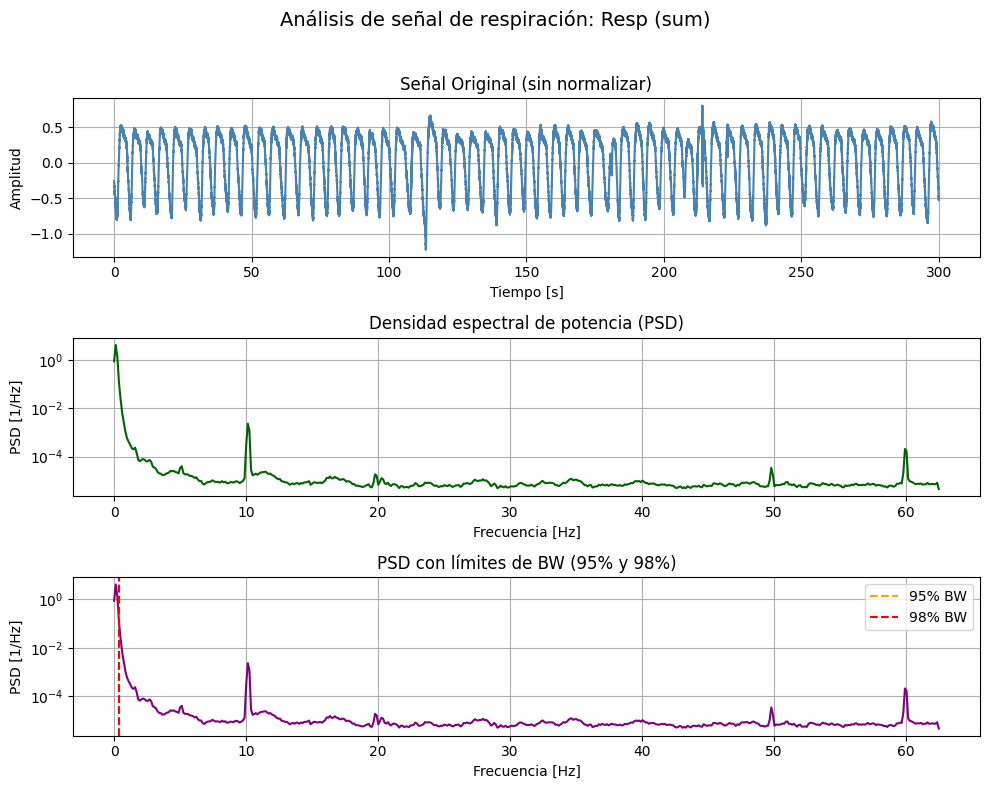

In [3]:
#%% Carga de modulos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.integrate import cumulative_trapezoid

#%% Cargo archivo CSV

csv_path = "slp01a_respiration.csv"  # Asegurate de tenerlo en el mismo directorio
df = pd.read_csv(csv_path)

#%% Me quedo con los primeros 300 segundos de datos

df_300 = df[df["Time [s]"] <= 300]
time = df_300["Time [s]"]
signal_columns = df_300.columns[1:]  # Elijo todas las columnas menos la primera que contiene los indices de tiempo


fs = 125  # Frecuencia de muestreo en Hz - Tome una fs acorde a como es la respiracion

#%% Procesamiento de la señal

for col in signal_columns:
    raw_signal = df_300[col].values

    # --- Normalización ---
    normalized_signal = (raw_signal - np.mean(raw_signal)) / np.std(raw_signal)

    # --- Cálculo de PSD usando Welch ---
    f, psd = welch(normalized_signal, fs=fs, nperseg=1024)

    # --- Calcular bandas de frecuencia (95% y 98%) ---
    cumulative_psd = cumulative_trapezoid(psd, f, initial=0)
    total_power = cumulative_psd[-1]

    f_95 = f[np.where(cumulative_psd >= 0.95 * total_power)[0][0]]
    f_98 = f[np.where(cumulative_psd >= 0.98 * total_power)[0][0]]

    print(f"Señal: {col}")
    print(f"  BW 95%: {f_95:.3f} Hz")
    print(f"  BW 98%: {f_98:.3f} Hz")

    # === 5. Graficar ===
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    fig.suptitle(f"Análisis de señal de respiración: {col}", fontsize=14)

    # Señal original
    axs[0].plot(time, raw_signal, color='steelblue')
    axs[0].set_title("Señal Original (sin normalizar)")
    axs[0].set_xlabel("Tiempo [s]")
    axs[0].set_ylabel("Amplitud")
    axs[0].grid(True)

    # PSD
    axs[1].semilogy(f, psd, color='darkgreen')
    axs[1].set_title("Densidad espectral de potencia (PSD)")
    axs[1].set_xlabel("Frecuencia [Hz]")
    axs[1].set_ylabel("PSD [1/Hz]")
    axs[1].grid(True)

    # PSD con BW
    axs[2].semilogy(f, psd, color='purple')
    axs[2].axvline(f_95, color='orange', linestyle='--', label='95% BW')
    axs[2].axvline(f_98, color='red', linestyle='--', label='98% BW')
    axs[2].set_title("PSD con límites de BW (95% y 98%)")
    axs[2].set_xlabel("Frecuencia [Hz]")
    axs[2].set_ylabel("PSD [1/Hz]")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### ¿Por qué el BW es tan pequeño (~0.3 Hz)?

La respiración humana normalmente tiene una frecuencia baja, en torno a 0.2 a 0.4 Hz (equivalente a 12 a 24 respiraciones por minuto). Las señales respiratorias reflejan oscilaciones lentas; por eso, la mayor parte de la potencia espectral está concentrada en frecuencias bajas. El ancho de banda (BW) calculado muestra que casi toda la energía de la señal está en ese rango bajo, con poca energía en frecuencias más altas o ruido.

### Interpretación fisiológica

Un BW de ~0.3 Hz indica un ciclo respiratorio de aproximadamente 3.3 segundos (1/0.3 Hz). Si la respiración fuera más rápida (por ejemplo 0.5 Hz), la potencia espectral se desplazaría hacia frecuencias más altas y el BW sería mayor. El BW pequeño confirma que la señal es bastante “concentrada” en bajas frecuencias, lo cual es típico para señales de respiración.

### Conclusión

Al principio creía que el BW tan pequeño estaba errado, ya que, a diferencia de las otras señales que analizamos este fue muy inferior, con esto en mente investigué un poco y como antes se expuso este resultado es algo de la propia fisiología de la respiración, por lo que tiene sentido. Entonces el BW pequeño no es un error ni una limitación, sino que refleja la naturaleza fisiológica de la respiración: una señal lenta y de baja frecuencia.
